In [1]:
# Import libraries and packages
import pandas as pd
import numpy as np
import re
from gensim import corpora, models, similarities, matutils
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize,RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import time

C:\Users\ASUS\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Data Pre-processing##

In [2]:
# Import Dataset and remove empty rows
df = pd.read_csv('Foodsaver_1.csv')
# df = df.dropna(subset=['reviews.text'])
df

,reviews.rating,reviews.text
0,1,I am thinking it is ready to use. I did not kn...
1,1,I bought this a month ago. I tried vacuum seal...
2,1,the first one I received would not work at all...
3,1,I cannot make heads or tails out of how to use...
4,1,I have tried to use all and found that none of...
5,1,Seal did not hold. I buy a lot of foodsaver pr...
6,1,I tried numerous times and it doesn't stay sea...
7,1,I did not like the item because the item did n...
8,1,"We bought this container as part of a package,..."
9,1,"I really liked the earlier versions of these, ..."


In [3]:
# data overview
print ('Rows     : ', df.shape[0])
print ('Columns  : ', df.shape[1])
print ('\nFeatures : ', df.columns.tolist())
print ('\nMissing values :  ', df.isnull().sum().values.sum())
print ('\nUnique values :  \n', df.nunique())

Rows     :  44
Columns  :  2

Features :  ['reviews.rating', 'reviews.text']

Missing values :   0

Unique values :  
 reviews.rating     1
reviews.text      44
dtype: int64


In [4]:
df.info()
df.isnull().sum()

reviews.rating    0
reviews.text      0
dtype: int64

In [8]:
# Remove punctuation 
df['no_punctuation'] = df['reviews.text'].str.replace('[^\w\s]','')

# Change to lower case
df ['lower_case'] = df['no_punctuation'].astype(str).str.lower()

# Apply word tokenizer
df['tokenized_text'] = df['lower_case'].apply(word_tokenize)
# df.to_csv("df_tokenized_text.csv", index=True)

# Remove stop words
df['key_words'] =df['tokenized_text'].apply(lambda x: [item for item in x if item not in stopwords.words('english')])
# df.to_csv("df_stop_words.csv", index=True)

# # Word stemming
# porter_stemmer = PorterStemmer()
# df['stem']=df['key_words'].apply(lambda x : [porter_stemmer.stem(y) for y in x])
# # df.to_csv("df_stem.csv", index=True)
df

,reviews.rating,reviews.text,no_punctuation,lower_case,tokenized_text,key_words
0,1,I am thinking it is ready to use. I did not kn...,I am thinking it is ready to use I did not kno...,i am thinking it is ready to use i did not kno...,"[i, am, thinking, it, is, ready, to, use, i, d...","[thinking, ready, use, know, needed, buy, part..."
1,1,I bought this a month ago. I tried vacuum seal...,I bought this a month ago I tried vacuum seali...,i bought this a month ago i tried vacuum seali...,"[i, bought, this, a, month, ago, i, tried, vac...","[bought, month, ago, tried, vacuum, sealing, s..."
2,1,the first one I received would not work at all...,the first one I received would not work at all...,the first one i received would not work at all...,"[the, first, one, i, received, would, not, wor...","[first, one, received, would, work, replaced, ..."
3,1,I cannot make heads or tails out of how to use...,I cannot make heads or tails out of how to use...,i cannot make heads or tails out of how to use...,"[i, can, not, make, heads, or, tails, out, of,...","[make, heads, tails, use, product, sell, parts..."
4,1,I have tried to use all and found that none of...,I have tried to use all and found that none of...,i have tried to use all and found that none of...,"[i, have, tried, to, use, all, and, found, tha...","[tried, use, found, none, containers, hold, va..."
5,1,Seal did not hold. I buy a lot of foodsaver pr...,Seal did not hold I buy a lot of foodsaver pro...,seal did not hold i buy a lot of foodsaver pro...,"[seal, did, not, hold, i, buy, a, lot, of, foo...","[seal, hold, buy, lot, foodsaver, products, fi..."
6,1,I tried numerous times and it doesn't stay sea...,I tried numerous times and it doesnt stay seal...,i tried numerous times and it doesnt stay seal...,"[i, tried, numerous, times, and, it, doesnt, s...","[tried, numerous, times, doesnt, stay, sealed,..."
7,1,I did not like the item because the item did n...,I did not like the item because the item did n...,i did not like the item because the item did n...,"[i, did, not, like, the, item, because, the, i...","[like, item, item, say, sealed]"
8,1,"We bought this container as part of a package,...",We bought this container as part of a package ...,we bought this container as part of a package ...,"[we, bought, this, container, as, part, of, a,...","[bought, container, part, package, three, cont..."
9,1,"I really liked the earlier versions of these, ...",I really liked the earlier versions of these d...,i really liked the earlier versions of these d...,"[i, really, liked, the, earlier, versions, of,...","[really, liked, earlier, versions, decided, ge..."


## Count Vectorizing ##

In [9]:
# Join the tokenized words for count vectorizing
df['joined_Sent'] = [' '.join(map(str, indStem)) for indStem in df['key_words']]
df

,reviews.rating,reviews.text,no_punctuation,lower_case,tokenized_text,key_words,joined_Sent
0,1,I am thinking it is ready to use. I did not kn...,I am thinking it is ready to use I did not kno...,i am thinking it is ready to use i did not kno...,"[i, am, thinking, it, is, ready, to, use, i, d...","[thinking, ready, use, know, needed, buy, part...",thinking ready use know needed buy parts make ...
1,1,I bought this a month ago. I tried vacuum seal...,I bought this a month ago I tried vacuum seali...,i bought this a month ago i tried vacuum seali...,"[i, bought, this, a, month, ago, i, tried, vac...","[bought, month, ago, tried, vacuum, sealing, s...",bought month ago tried vacuum sealing sealing ...
2,1,the first one I received would not work at all...,the first one I received would not work at all...,the first one i received would not work at all...,"[the, first, one, i, received, would, not, wor...","[first, one, received, would, work, replaced, ...",first one received would work replaced without...
3,1,I cannot make heads or tails out of how to use...,I cannot make heads or tails out of how to use...,i cannot make heads or tails out of how to use...,"[i, can, not, make, heads, or, tails, out, of,...","[make, heads, tails, use, product, sell, parts...",make heads tails use product sell parts need
4,1,I have tried to use all and found that none of...,I have tried to use all and found that none of...,i have tried to use all and found that none of...,"[i, have, tried, to, use, all, and, found, tha...","[tried, use, found, none, containers, hold, va...",tried use found none containers hold vacuum on...
5,1,Seal did not hold. I buy a lot of foodsaver pr...,Seal did not hold I buy a lot of foodsaver pro...,seal did not hold i buy a lot of foodsaver pro...,"[seal, did, not, hold, i, buy, a, lot, of, foo...","[seal, hold, buy, lot, foodsaver, products, fi...",seal hold buy lot foodsaver products fixin dis...
6,1,I tried numerous times and it doesn't stay sea...,I tried numerous times and it doesnt stay seal...,i tried numerous times and it doesnt stay seal...,"[i, tried, numerous, times, and, it, doesnt, s...","[tried, numerous, times, doesnt, stay, sealed,...",tried numerous times doesnt stay sealed 12 hours
7,1,I did not like the item because the item did n...,I did not like the item because the item did n...,i did not like the item because the item did n...,"[i, did, not, like, the, item, because, the, i...","[like, item, item, say, sealed]",like item item say sealed
8,1,"We bought this container as part of a package,...",We bought this container as part of a package ...,we bought this container as part of a package ...,"[we, bought, this, container, as, part, of, a,...","[bought, container, part, package, three, cont...",bought container part package three containers...
9,1,"I really liked the earlier versions of these, ...",I really liked the earlier versions of these d...,i really liked the earlier versions of these d...,"[i, really, liked, the, earlier, versions, of,...","[really, liked, earlier, versions, decided, ge...",really liked earlier versions decided get upda...


In [10]:
# Document-Term Matrix (Count Vectorizer)
word_vectorizer = CountVectorizer(ngram_range=(1,3), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df["joined_Sent"])
df_doc_term = pd.DataFrame(sparse_matrix.toarray(), columns=word_vectorizer.get_feature_names())
df_doc_term.shape
# df_doc_term.to_csv("df_doc_term.csv", index=True)

(44, 2187)

In [11]:
df_doc_term

,10,10 cup,10 cup container,10 cup containers,10 min,10 min trying,10c,10c rectangular,10c rectangular container,12,...,years happy two,years new,years new containers,yesterday,yesterday upon,yesterday upon first,zip,zip lock,zip lock bag,zip lock bags
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Topic Modelling - Count Vectorizer ##

### 1. Gensim###

In [12]:
time1 = time.time()
# Convert sparse matrix of counts to a gensim corpus 
corpus = matutils.Sparse2Corpus(sparse_matrix)
# Map matrix rows to words (tokens)
id2word = dict((v, k) for k, v in word_vectorizer.vocabulary_.items())
# len(id2word)
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=5)
# 10 most important words for each of the 3 topics
lda.print_topics()
# Transform the docs from word space to topic space
lda_corpus = lda[corpus]
# Store the doc topic vectors in a list for review
lda_docs = [doc for doc in lda_corpus]
# Find the document vectors in the topic space for the first 10 documents
lda_docs[0:10] 
time2 = time.time()
time_taken = time2 - time1
print(time_taken)

1.8400681018829346


In [13]:
lda.print_topics()

[(0,
  '0.121*"absolutely" + 0.102*"accessories hoping answer" + 0.069*"10 cup container" + 0.045*"abut 10 min" + 0.036*"10 cup" + 0.030*"absolutely useless" + 0.029*"able" + 0.028*"24 hrs bad" + 0.023*"12 hours" + 0.023*"absolutely useless regular"'),
 (1,
  '0.130*"abut 10" + 0.066*"2nd time see" + 0.055*"2nd time" + 0.054*"12" + 0.051*"abut" + 0.050*"accessories" + 0.036*"24 hrs" + 0.034*"able get seal" + 0.034*"advertised seal two" + 0.030*"24 hours"'),
 (2,
  '0.113*"abysmal" + 0.069*"ago" + 0.067*"30 seconds" + 0.054*"10c rectangular container" + 0.036*"advertised seal" + 0.032*"24" + 0.030*"able get" + 0.028*"24 hours sometimes" + 0.018*"30" + 0.011*"10"')]

### 2.  LSA aka SVD###

In [14]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(3)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3"],
             columns = word_vectorizer.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 10 key words for each of the 6 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, word_vectorizer.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
seal, containers, container, vacuum, hold, use, well, bought, work, new, keep, days, hold seal, dont, would, lids, set, keep seal, smoked, things

Topic  1
vacuum, storage, dont, bought, lids, set, container, using, lids dont, storage containers, time, ago, stay, bought set, months, one, months ago, couple, expensive, floor

Topic  2
seal, ones, foodsaver, long, long time, square, time, really, one, container, reliable, hold, love, hold seal, good, reason, know, bad, dont know, seems
0.05186057090759277


In [15]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(2)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2"],
             columns = word_vectorizer.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 10 key words for each of the 2 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, word_vectorizer.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
seal, containers, container, vacuum, hold, use, well, bought, work, new, keep, days, hold seal, dont, would, lids, set, things, keep seal, smoked

Topic  1
vacuum, storage, dont, bought, lids, set, container, using, lids dont, storage containers, time, ago, months, bought set, stay, one, months ago, couple, expensive, store
0.014957189559936523


### 3. Non-Negative Matrix Factorization (NMF)### 

In [16]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(3)
doc_topic = nmf_model.fit_transform(df_doc_term)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3"],
             columns = word_vectorizer.get_feature_names())
topic_word
display_topics(nmf_model, word_vectorizer.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
seal, containers, well, keep, work, new, hold, smoked, things, keep seal, days, use, container, would, two, hold seal, three, old, anymore, lock

Topic  1
vacuum, containers, storage, lids, dont, bought, using, lids dont, storage containers, container, ago, months, months ago, set, couple, expensive, store, containers months, containers months ago, floor

Topic  2
seal, foodsaver, ones, time, long, long time, use, containers, set, one, container, bought, dont, square, really, reliable, good, know, dont know, seems
0.05884218215942383


In [17]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(2)
doc_topic = nmf_model.fit_transform(df_doc_term)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2"],
             columns = word_vectorizer.get_feature_names())
topic_word
display_topics(nmf_model, word_vectorizer.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
seal, containers, well, keep, container, hold, use, new, work, hold seal, things, keep seal, smoked, would, days, two, three, square, bought, anymore

Topic  1
vacuum, containers, storage, lids, dont, bought, using, lids dont, storage containers, set, ago, container, stay, months, months ago, expensive, store, couple, containers months ago, floor
0.028920888900756836


## Topic Modelling - TF-IDF Vectorizer##

In [18]:
# Document-Term Matrix - TF-IDF
cv_tfidf = TfidfVectorizer(ngram_range=(1,3), analyzer='word')
sparse_matrix = cv_tfidf.fit_transform(df["joined_Sent"])
df_doc_term_TFIDF = pd.DataFrame(sparse_matrix.toarray(), columns=cv_tfidf.get_feature_names())
df_doc_term_TFIDF.shape
# df_doc_term_TFIDF.to_csv("df_doc_term_TFIDF.csv", index=True)

(44, 2187)

In [19]:
df_doc_term_TFIDF

,10,10 cup,10 cup container,10 cup containers,10 min,10 min trying,10c,10c rectangular,10c rectangular container,12,...,years happy two,years new,years new containers,yesterday,yesterday upon,yesterday upon first,zip,zip lock,zip lock bag,zip lock bags
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.233246,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### 1. Gensim###

In [20]:
lda.print_topics()
time1 = time.time()
# Convert sparse matrix of counts to a gensim corpus 
corpus = matutils.Sparse2Corpus(sparse_matrix)
# Map matrix rows to words (tokens)
id2word = dict((v, k) for k, v in cv_tfidf.vocabulary_.items())
# len(id2word)
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=5)
# 10 most important words for each of the 3 topics
lda.print_topics()
# Transform the docs from word space to topic space
lda_corpus = lda[corpus]
# Store the doc topic vectors in a list for review
lda_docs = [doc for doc in lda_corpus]
# Find the document vectors in the topic space for the first 10 documents
lda_docs[0:10] 
time2 = time.time()
time_taken = time2 - time1
print(time_taken)

1.3912785053253174


In [21]:
lda.print_topics()

[(0,
  '0.018*"abysmal" + 0.016*"abut 10 min" + 0.013*"abut" + 0.013*"absolutely" + 0.010*"ago" + 0.010*"accessories hoping answer" + 0.010*"2nd time" + 0.009*"10 cup" + 0.008*"24 hours" + 0.008*"24 hrs"'),
 (1,
  '0.009*"advertised seal two" + 0.009*"2nd time see" + 0.009*"30 seconds sealing" + 0.007*"advertised" + 0.006*"24 hrs bad" + 0.004*"10" + 0.004*"30" + 0.003*"absolutely" + 0.003*"abut 10" + 0.003*"accessories"'),
 (2,
  '0.016*"abut 10" + 0.014*"10 cup container" + 0.011*"30 seconds" + 0.010*"10c rectangular container" + 0.008*"accessories" + 0.007*"accessories hoping" + 0.007*"12" + 0.007*"2nd time see" + 0.007*"24" + 0.007*"10 min"')]

### 2. LSA aka SVD###

In [22]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(3)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term_TFIDF)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3"],
             columns = cv_tfidf.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 10 key words for each of the 6 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
seal, containers, hold, vacuum, container, bought, one, work, day, hold vacuum, hold seal, get, dont, use, lids, expensive, sealed, two, tried, ago

Topic  1
seal, get, get seal, able get, able get seal, able, get seal last, seal last one, last one, seal last, last, last one day, ive, one day, hold seal, day, held seal, held, seal hold, clear

Topic  2
use, know, dont, work, parts, make, foodsaver, seems, dont know, use foodsaver, missing, use foodsaver seems, foodsaver seems, foodsaver seems like, like something, dont know use, seems like, seems like something, like something missing, something missing
0.014958858489990234


In [23]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(2)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term_TFIDF)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2"],
             columns = cv_tfidf.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 10 key words for each of the 6 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
seal, containers, hold, vacuum, container, bought, work, one, day, dont, hold seal, hold vacuum, use, get, lids, two, new, ago, expensive, set

Topic  1
seal, get, get seal, able get, able get seal, able, one day, ive, last, last one, last one day, get seal last, seal last one, seal last, hold seal, 10, suction, washed, piece, day
0.01695418357849121


### 3. Non-Negative Matrix Factorization (NMF)###

In [24]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(3)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3"],
             columns = cv_tfidf.get_feature_names())
topic_word
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
seal, containers, hold, container, get, vacuum, day, hold vacuum, hold seal, one, one day, able, get seal, able get, able get seal, hold vacuum one, vacuum one, none, three, held

Topic  1
sealed, stay sealed, stay, bought four, pieces container, pieces container stay, container stay sealed, bought four pieces, pieces, four pieces container, four pieces, container stay, four, item, purchase, 12 hours, times doesnt stay, doesnt stay sealed, numerous times, numerous

Topic  2
bought, dont, lids, use, work, foodsaver, sealing, ago, month, month ago, know, containers, first, vacuum, vacuum sealing, snap, two, time, stays, something
0.09375


In [25]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(2)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2"],
             columns = cv_tfidf.get_feature_names())
topic_word
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
vacuum, containers, work, bought, hold vacuum, lids, tried, hold, use, dont, one, sealed, hold vacuum one, vacuum one, even, day, stay, expensive, sealing, container

Topic  1
seal, hold seal, container, containers, get, hold, get seal, able get seal, able get, able, square, day, held, ive, purchased, get seal last, last one day, last one, last, seal last
0.0857694149017334


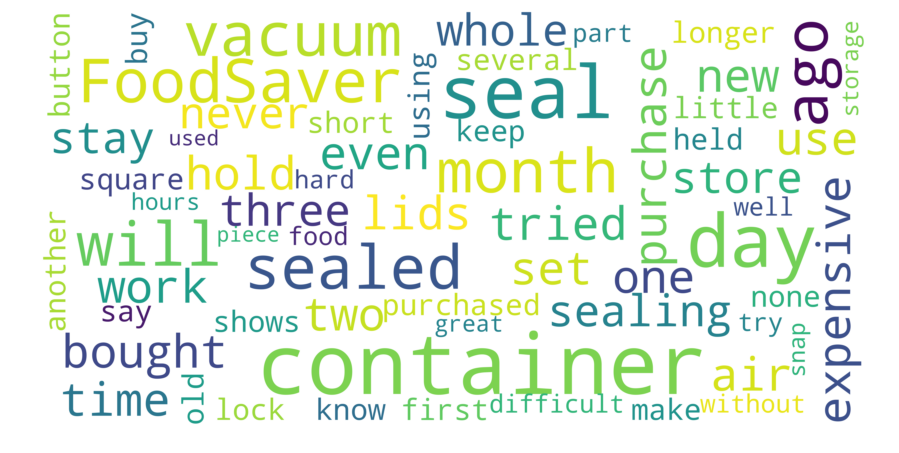

In [29]:
# Visualise using word cloud
from wordcloud import WordCloud
import matplotlib as plt
import matplotlib.pyplot as plt

split_title = [x.split(" ") for x in df['reviews.text'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()

wordcloud = WordCloud(background_color='white', max_words=400, max_font_size=40, scale=30,
        random_state=1).generate((listCounts[listCounts > 2]).to_string())
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()